# Assignment Week 10/11: Document Classification
CUNY IS620 - Web Analytics

Robert Sellers | November 14, 2016

The following outlines a process that reads a sample from existing classified "SPAM" versus "HAM" SMS/Text messages, [Raw Data File Here](https://raw.githubusercontent.com/RobertSellers/dataWarehouse/master/SMSSpamCollection), into a training corpus. A model is then learned from this to then predict messages from the same corpus. Inspired and applied from the following [python notebook](http://radimrehurek.com/data_science_python/).

## Initialization

**Requiring libraries**

- pandas
- matplotlib 
- sklean 
- textblob
- nltk

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import csv
from textblob import TextBlob
import pandas
import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from nltk.classify import apply_features

**Reading the .tsv Data File into corpus with Pandas and aggregating statistics**

In [2]:
messages = pandas.read_csv('https://raw.githubusercontent.com/RobertSellers/dataWarehouse/master/SMSSpamCollection'
                           , sep='\t', quoting=csv.QUOTE_NONE,names=["label", "message"])
messages.groupby('label').describe()

message
label                                                          
ham   count                                                4827
      unique                                               4518
      top                                Sorry, I'll call later
      freq                                                   30
spam  count                                                 747
      unique                                                653
      top     Please call our customer service representativ...
      freq                                                    4

In total there are 5574 SMS messages.

## Analysis

In [3]:
messages['length'] = messages['message'].map(lambda text: len(text))
print messages.head()

  label                                            message  length
0   ham  Go until jurong point, crazy.. Available only ...     111
1   ham                      Ok lar... Joking wif u oni...      29
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...     155
3   ham  U dun say so early hor... U c already then say...      49
4   ham  Nah I don't think he goes to usf, he lives aro...      61


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000000AC4CF28>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000000000AD443C8>], dtype=object)

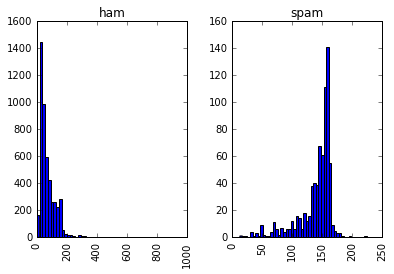

In [4]:
messages.hist(column='length', by='label', bins=50)

It is evident in the above graph that the ham and spam length distributions differ substantially.

## Processing

**Creating testing and training datasets**

In [6]:
train_set = messages[0:3000]
test_set = messages[3000:5574]

**Splitting by Token**

In [7]:
def split_into_tokens(message):
    message = unicode(message, 'utf8')  # convert bytes into proper unicode
    return TextBlob(message).words

train_set.message.head().apply(split_into_tokens)

0    [Go, until, jurong, point, crazy, Available, o...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, in, 2, a, wkly, comp, to, win, F...
3    [U, dun, say, so, early, hor, U, c, already, t...
4    [Nah, I, do, n't, think, he, goes, to, usf, he...
Name: message, dtype: object

**Defining by lemma**

In [8]:
def split_into_lemmas(message):
    message = unicode(message, 'utf8').lower()
    words = TextBlob(message).words
    # for each word, take its "base form" = lemma 
    return [word.lemma for word in words]

train_set.message.head().apply(split_into_lemmas)

0    [go, until, jurong, point, crazy, available, o...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, in, 2, a, wkly, comp, to, win, f...
3    [u, dun, say, so, early, hor, u, c, already, t...
4    [nah, i, do, n't, think, he, go, to, usf, he, ...
Name: message, dtype: object

**Character to Vector and Bag of Words conversion**

In [9]:
#Counts unique words - BOW = BAG OF WORDS
bow_transformer = CountVectorizer(analyzer=split_into_lemmas).fit(train_set['message'])
#conversion of results into a sparse matrix
messages_bow = bow_transformer.transform(train_set['message'])
print 'sparse matrix shape:', messages_bow.shape
print 'number of non-zeros:', messages_bow.nnz
print 'sparsity: %.2f%%' % (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))

sparse matrix shape: (4000, 7388)
number of non-zeros: 57632
sparsity: 0.20%


Each vector has as many dimensions as there are unique words in the SMS corpus.

**Bag of Words conversion into Term-Frequency, Inverse Document Frequency Corpus**

The tfidf applies a statistical value reflecting the importance of each word in the bow matrix. 

In [8]:
tfidf_transformer = TfidfTransformer().fit(messages_bow)
messages_tfidf = tfidf_transformer.transform(messages_bow)

## Model results

In [9]:
#using a Naive-Bayes Classification
spam_detector = MultinomialNB().fit(messages_tfidf, messages['label'])
all_predictions = spam_detector.predict(messages_tfidf)

**ACCURACY**

In [10]:
print 'accuracy', accuracy_score(messages['label'], all_predictions)

accuracy 0.969501255831


**CONFUSION MATRIX**

In [11]:
print 'confusion matrix\n', confusion_matrix(messages['label'], all_predictions)
print '(row=expected, col=predicted)'

confusion matrix
[[4827    0]
 [ 170  577]]
(row=expected, col=predicted)


**CLASSIFICATION REPORT**

In [12]:
print classification_report(messages['label'], all_predictions)

             precision    recall  f1-score   support

        ham       0.97      1.00      0.98      4827
       spam       1.00      0.77      0.87       747

avg / total       0.97      0.97      0.97      5574

